In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


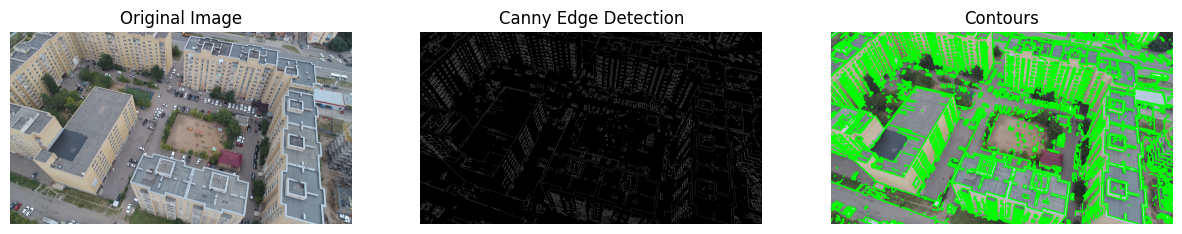

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('/content/drive/MyDrive/Data/DJI_0538.JPG')
# img = cv2.imread('/content/drive/MyDrive/Data/DSC01050.JPG')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11,11), 0)

high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.03 * high_thresh
edges = cv2.Canny(blurred, lowThresh, high_thresh, 5)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 20)

plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Canny edge detection result
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

# Contours on the original image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')

plt.show()


#RUN

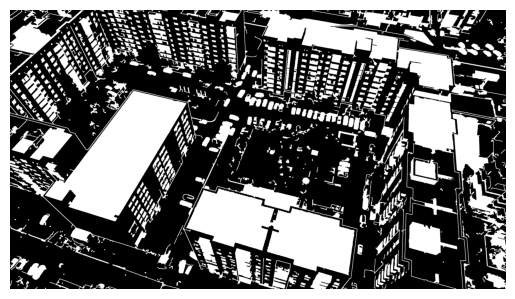

In [ ]:
import cv2
from osgeo import gdal, ogr
import numpy as np
import matplotlib.pyplot as plt

# Read the image
# img = cv2.imread('/content/drive/MyDrive/Data/DJI_0231.JPG')
archived_img = img

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


lower_green = np.array([35, 40, 40])  # Adjust as needed
upper_green = np.array([100, 255, 255])  # Adjust as needed

lower_brown = np.array([10, 40, 40])  # Adjust as needed
upper_brown = np.array([30, 255, 255])  # Adjust as needed

green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
brown_mask = cv2.inRange(img_hsv, lower_brown, upper_brown)

vegetation_mask = cv2.bitwise_or(green_mask, brown_mask)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11,11), 0)

high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.03 * high_thresh
edges = cv2.Canny(blurred, lowThresh, high_thresh, 5)

# Perform morphological transformations to enhance contours
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Find contours in the processed image
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a black image
contour_img = np.zeros_like(img)
cv2.drawContours(contour_img, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# Create a raster file using GDAL
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('/content/drive/MyDrive/Data/contours.tif', img.shape[1], img.shape[0], 1, gdal.GDT_Byte)
ds.GetRasterBand(1).WriteArray(contour_img[:, :, 0])
ds.FlushCache()
ds = None

# Use GDAL Polygonize to convert raster to vector features
src_ds = gdal.Open('/content/drive/MyDrive/Data/contours.tif')
vector_ds = ogr.GetDriverByName("Memory").CreateDataSource("mem_data")
vector_layer = vector_ds.CreateLayer("contours", geom_type=ogr.wkbPolygon)

gdal.Polygonize(src_ds.GetRasterBand(1), None, vector_layer, 0, [], callback=None)

# Close the datasets
output_ds = None
vector_ds = None
src_ds = None

dataset = gdal.Open(r'/content/drive/MyDrive/Data/contours.tif')
band1 = dataset.GetRasterBand(1)
b1 = band1.ReadAsArray()

# Save the single-band image as PNG directly
plt.imsave('Tiff.png', b1, cmap='gray')

# Display the image using matplotlib
f = plt.figure()
plt.imshow(b1, cmap='gray')
plt.axis('off')
plt.show()


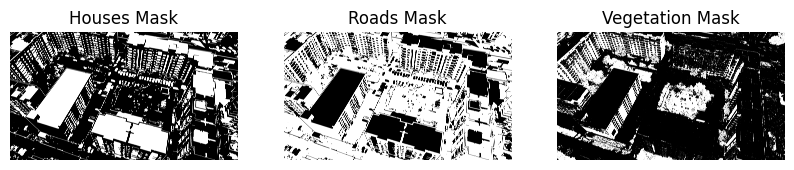

In [ ]:
import cv2
import numpy as np
from osgeo import gdal, ogr

# Read the GeoTIFF image
dataset = gdal.Open('/content/drive/MyDrive/Data/contours.tif')
band1 = dataset.GetRasterBand(1)
img = band1.ReadAsArray()


_, houses_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otsu's thresholding for roads
_, roads_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
roads_mask = cv2.bitwise_not(roads_mask)



# Display the masks using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(houses_mask, cmap='gray')
plt.title('Houses Mask')
plt.axis('off')

plt.subplot(132)
plt.imshow(roads_mask, cmap='gray')
plt.title('Roads Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(vegetation_mask, cmap='gray')
plt.title('Vegetation Mask')
plt.axis('off')

plt.show()


# Contour analysis to extract polygonized regions
houses_contours, _ = cv2.findContours(houses_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roads_contours, _ = cv2.findContours(roads_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
vegetation_contours, _ = cv2.findContours(vegetation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Extracted polygonized regions without using cv2.approxPolyDP
houses_polygons = [contour for contour in houses_contours]
roads_polygons = [contour for contour in roads_contours]
vegetation_polygons = [contour for contour in vegetation_contours]



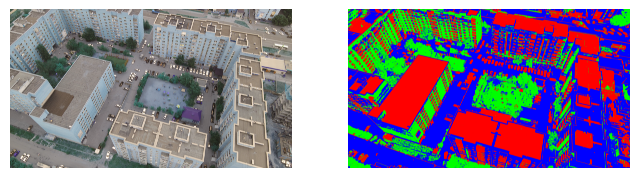

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def connect_masks(houses_mask, roads_mask, vegetation_mask):
    # Initialize an RGB image with zeros
    connected_img = np.zeros((houses_mask.shape[0], houses_mask.shape[1], 3), dtype=np.uint8)

    # Set red color for houses
    connected_img[houses_mask == 255] = [0, 0, 255]

    # Set blue color for roads
    connected_img[roads_mask == 255] = [255, 0, 0]

    # Set green color for vegetation
    connected_img[vegetation_mask == 255] = [0, 255, 0]


    return connected_img


# Assuming 'houses_mask', 'roads_mask', and 'vegetation_mask' are available
houses_mask = cv2.threshold(houses_mask, 0, 255, cv2.THRESH_BINARY)[1]
roads_mask = cv2.threshold(roads_mask, 0, 255, cv2.THRESH_BINARY)[1]

# Call the connect_masks function
connected_img = connect_masks(houses_mask, roads_mask, vegetation_mask)

# Display the connected image using matplotlib
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(archived_img)
plt.axis('off')  # Turn off axis labels

plt.subplot(122)
# colors = {'Cars, buildings, etc.': 'red', 'Roads and paveways': 'blue', 'Vegetation and ground': 'green'}
# legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in colors.items()]
# plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.imshow(cv2.cvtColor(connected_img, cv2.COLOR_BGR2RGB))
plt.axis('off')


plt.show()


# OTHERS

In [ ]:
# Import necessary libraries for feature extraction and machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd

# Function to extract features from a polygon
def extract_features(polygon):
    area = cv2.contourArea(polygon)
    perimeter = cv2.arcLength(polygon, True)
    return [area, perimeter]

# Extract features from each polygon and create a labeled dataset
data = []
labels = []

for polygon in houses_polygons:
    features = extract_features(polygon)
    data.append(features)
    labels.append('House')

for polygon in roads_polygons:
    features = extract_features(polygon)
    data.append(features)
    labels.append('Road')

for polygon in vegetation_polygons:
    features = extract_features(polygon)
    data.append(features)
    labels.append('Vegetation')

# Convert labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)

# Train a simple classifier (Random Forest in this example)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Now, you can use the trained model to classify polygons in the entire image
# ...

# Visualize or save the results
# ...


Accuracy: 1.00


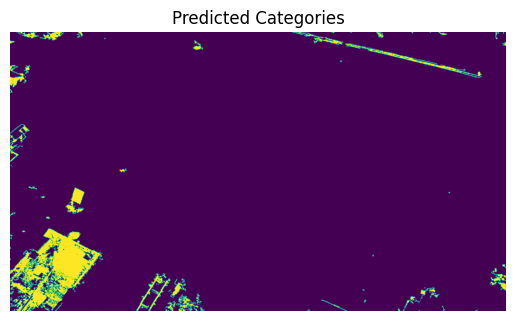

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'houses_polygons', 'roads_polygons', and 'vegetation_polygons' are lists of polygons

# Combine all polygons into one list
all_polygons = houses_polygons + roads_polygons + vegetation_polygons

# Extract features for each polygon (replace 'extract_features' with your feature extraction function)
all_data = [extract_features(polygon) for polygon in all_polygons]

# Predict categories for all polygons using the trained model
all_predictions = classifier.predict(all_data)

# Map numeric predictions back to original labels
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Visualize the results by coloring the polygons based on their predicted categories
result_img = np.zeros_like(img)

for i, polygon in enumerate(all_polygons):
    color = [0, 0, 0]  # Default color for unclassified polygons

    if predicted_labels[i] == 'House':
        color = [255, 0, 0]  # Red for houses
    elif predicted_labels[i] == 'Road':
        color = [0, 0, 255]  # Blue for roads
    elif predicted_labels[i] == 'Vegetation':
        color = [0, 255, 0]  # Green for vegetation

    cv2.drawContours(result_img, [polygon], -1, color, thickness=cv2.FILLED)

# Display the result
plt.imshow(result_img)
plt.title('Predicted Categories')
plt.axis('off')
plt.show()

# Save the result as an image
cv2.imwrite('/content/drive/MyDrive/Data/predicted_categories.tif', result_img)


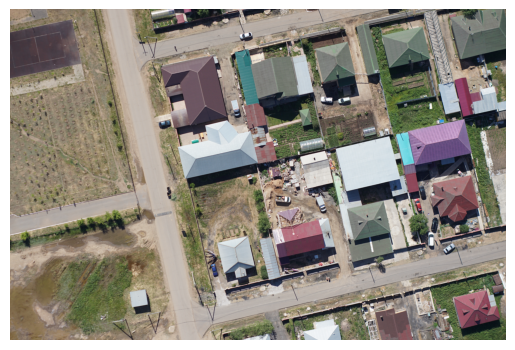

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Data/DSC00553.JPG')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()
